# LLM Energy & Performance Analysis Dashboard

**Comprehensive analysis of LLM performance metrics from energy.json data**

## What this analyzes:
- Model performance comparison (speed, tokens, efficiency)
- Energy consumption patterns and trends
- Token usage distribution across models
- Response time analysis
- Cost and efficiency metrics

## Setup:
1. Run `pip install -r requirements.txt` to install dependencies
2. Ensure `data/energy.json` exists with your experimental data
3. Run all cells to generate comprehensive analysis


In [37]:
# Import dependencies for comprehensive analysis
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("LLM Energy & Performance Analysis Dashboard")


LLM Energy & Performance Analysis Dashboard


In [38]:
# Load and parse energy data
def load_energy_data():
    try:
        with open('data/energy.json', 'r') as f:
            data = json.load(f)
        print(f"Loaded {len(data)} prompts from energy.json")
        return data
    except FileNotFoundError:
        print("Error: data/energy.json not found. Run gather_energy_data.ipynb first.")
        return []
    except Exception as e:
        print(f"Error loading data: {e}")
        return []

energy_data = load_energy_data()

if not energy_data:
    print("No data available for analysis.")
else:
    print(f"Data loaded successfully: {len(energy_data)} prompts analyzed")


Loaded 100 prompts from energy.json
Data loaded successfully: 100 prompts analyzed


In [39]:
# Flatten data for analysis - extract all model results
def flatten_energy_data(data):
    flattened = []
    
    for prompt in data:
        prompt_id = prompt.get('prompt_id', 'unknown')
        prompt_text = prompt.get('prompt_text', '')
        
        for model_name, model_result in prompt.get('models', {}).items():
            if model_result.get('model_info', {}).get('success', False):
                # Extract key metrics
                usage = model_result.get('usage_metrics', {})
                performance = model_result.get('performance', {})
                response = model_result.get('response_data', {})
                
                flattened.append({
                    'prompt_id': prompt_id,
                    'prompt_text': prompt_text[:100] + '...' if len(prompt_text) > 100 else prompt_text,
                    'model': model_name,
                    'duration_seconds': performance.get('duration_seconds', 0),
                    'prompt_tokens': usage.get('prompt_tokens', 0),
                    'completion_tokens': usage.get('completion_tokens', 0),
                    'total_tokens': usage.get('total_tokens', 0),
                    'tokens_per_second': usage.get('tokens_per_second', 0),
                    'estimated_energy_kwh': usage.get('estimated_energy_kwh', 0),
                    'energy_per_token': usage.get('energy_per_token', 0),
                    'response_length': len(response.get('content', '')),
                    'finish_reason': response.get('finish_reason', 'unknown')
                })
    
    return pd.DataFrame(flattened)

if energy_data:
    df = flatten_energy_data(energy_data)
    print(f"Flattened data: {len(df)} model results")
    print(f"Models: {df['model'].unique()}")
    print(f"Columns: {list(df.columns)}")
else:
    df = pd.DataFrame()
    print("No data to flatten.")


Flattened data: 299 model results
Models: ['openai' 'llama' 'mistral']
Columns: ['prompt_id', 'prompt_text', 'model', 'duration_seconds', 'prompt_tokens', 'completion_tokens', 'total_tokens', 'tokens_per_second', 'estimated_energy_kwh', 'energy_per_token', 'response_length', 'finish_reason']


In [40]:
# Overview statistics
if not df.empty:
    print(f"Data: {len(df)} experiments, {df['prompt_id'].nunique()} prompts, {df['total_tokens'].sum():,} tokens, {df['estimated_energy_kwh'].sum():.6f} kWh")
    
    # Model-specific stats
    model_stats = df.groupby('model').agg({
        'duration_seconds': ['count', 'mean'],
        'total_tokens': ['mean', 'sum'],
        'tokens_per_second': 'mean',
        'estimated_energy_kwh': ['sum', 'mean']
    }).round(3)
    
    print("\nModel Performance:")
    print(model_stats)
else:
    print("No data available.")


Data: 299 experiments, 100 prompts, 47,877 tokens, 3.579370 kWh

Model Performance:
        duration_seconds        total_tokens        tokens_per_second  \
                   count   mean         mean    sum              mean   
model                                                                   
llama                100  0.441      181.890  18189           424.340   
mistral               99  5.187      150.949  14944            50.644   
openai               100  1.006      147.440  14744           188.997   

        estimated_energy_kwh         
                         sum   mean  
model                                
llama                  0.909  0.009  
mistral                1.196  0.012  
openai                 1.474  0.015  


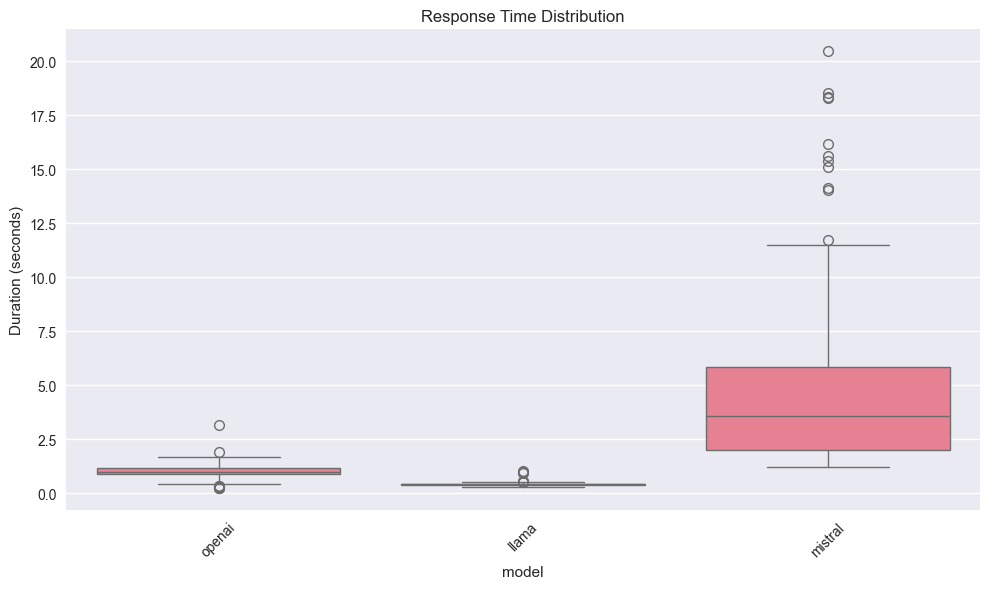

In [41]:
# Model Performance Comparison - Response Time
if not df.empty:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='model', y='duration_seconds')
    plt.title('Response Time Distribution')
    plt.ylabel('Duration (seconds)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No data available.")


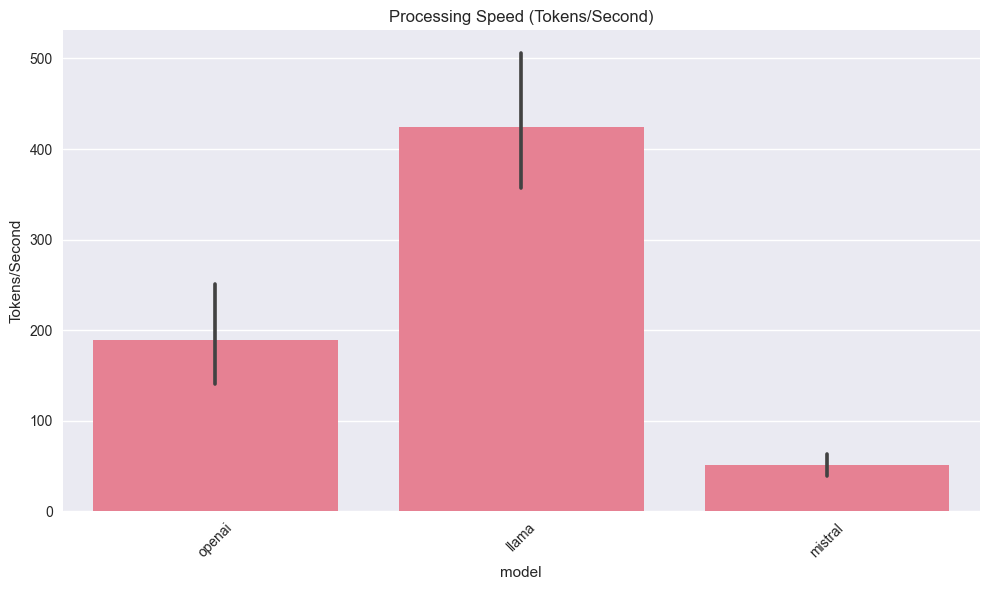

In [42]:
# Processing Speed Comparison
if not df.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='model', y='tokens_per_second')
    plt.title('Processing Speed (Tokens/Second)')
    plt.ylabel('Tokens/Second')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No data available.")


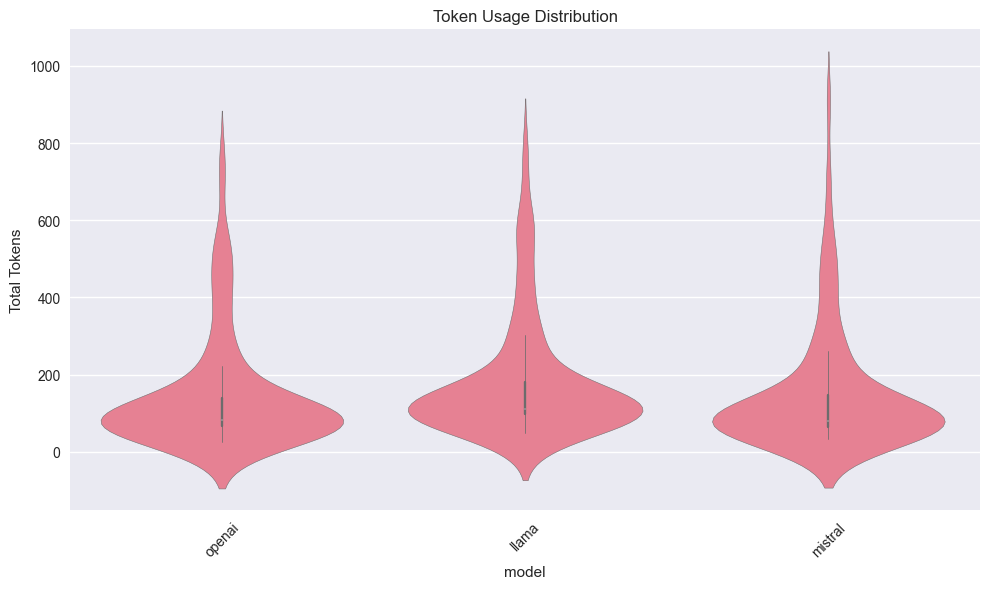

In [43]:
# Token Usage Distribution
if not df.empty:
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df, x='model', y='total_tokens')
    plt.title('Token Usage Distribution')
    plt.ylabel('Total Tokens')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No data available.")


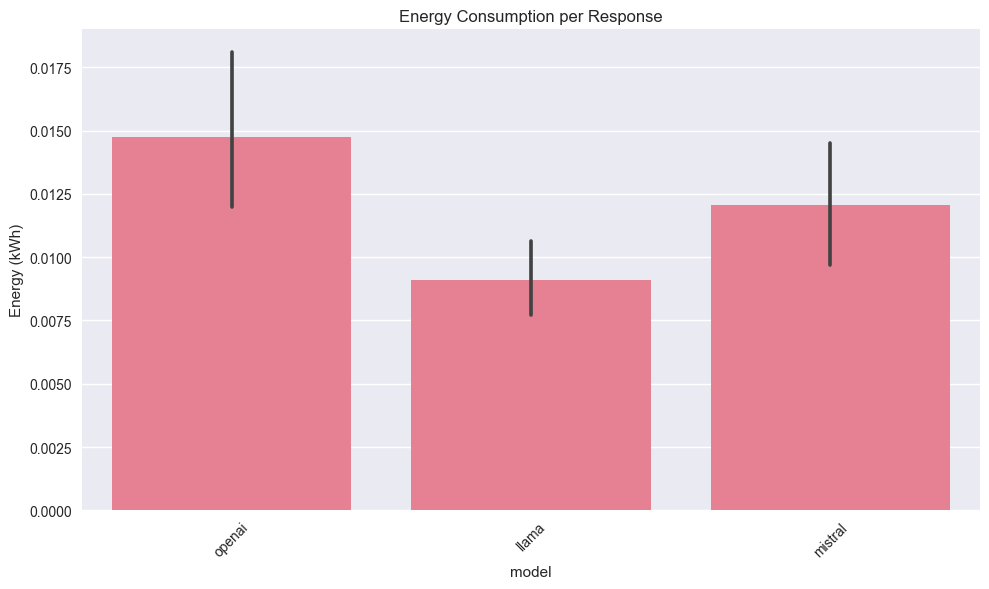

In [44]:
# Energy Consumption per Response
if not df.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='model', y='estimated_energy_kwh')
    plt.title('Energy Consumption per Response')
    plt.ylabel('Energy (kWh)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No data available.")


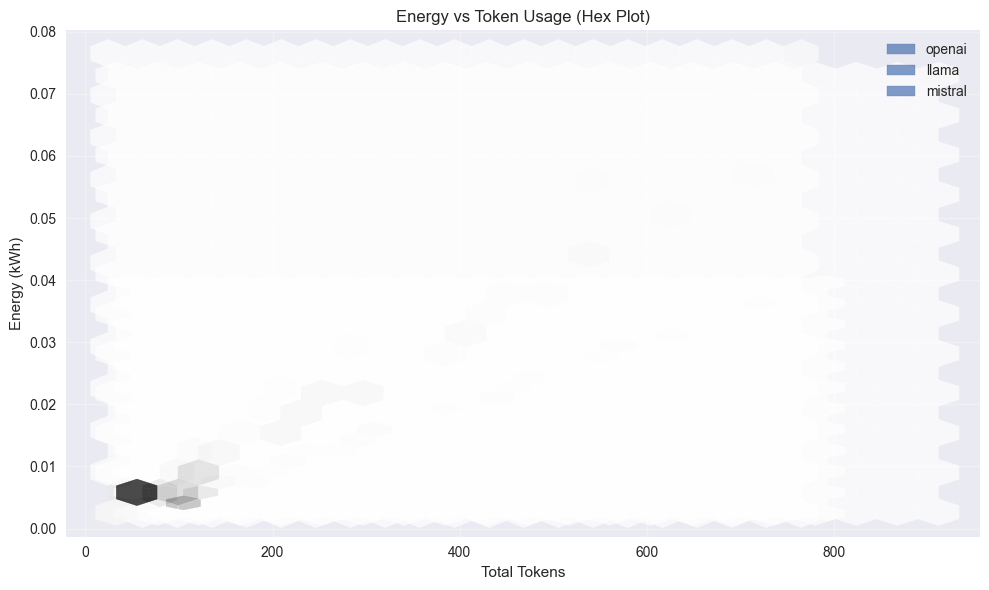

In [45]:
# Energy vs Tokens Hex Plot
if not df.empty:
    plt.figure(figsize=(10, 6))
    for model in df['model'].unique():
        model_data = df[df['model'] == model]
        plt.hexbin(model_data['total_tokens'], model_data['estimated_energy_kwh'], 
                  label=model, alpha=0.7, gridsize=20)
    plt.xlabel('Total Tokens')
    plt.ylabel('Energy (kWh)')
    plt.title('Energy vs Token Usage (Hex Plot)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No data available.")


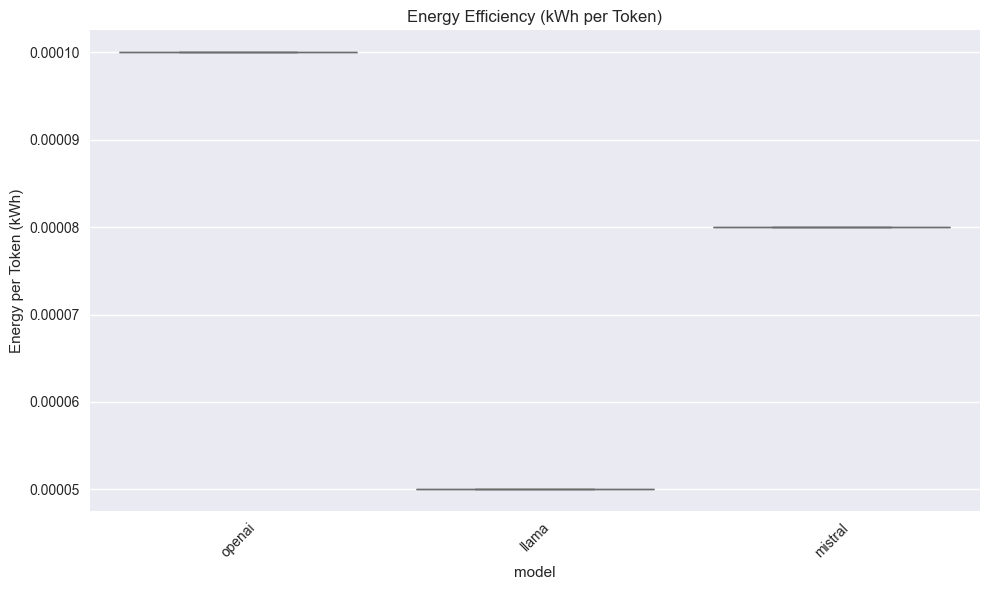

In [46]:
# Energy Efficiency (Energy per Token)
if not df.empty:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='model', y='energy_per_token')
    plt.title('Energy Efficiency (kWh per Token)')
    plt.ylabel('Energy per Token (kWh)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No data available.")


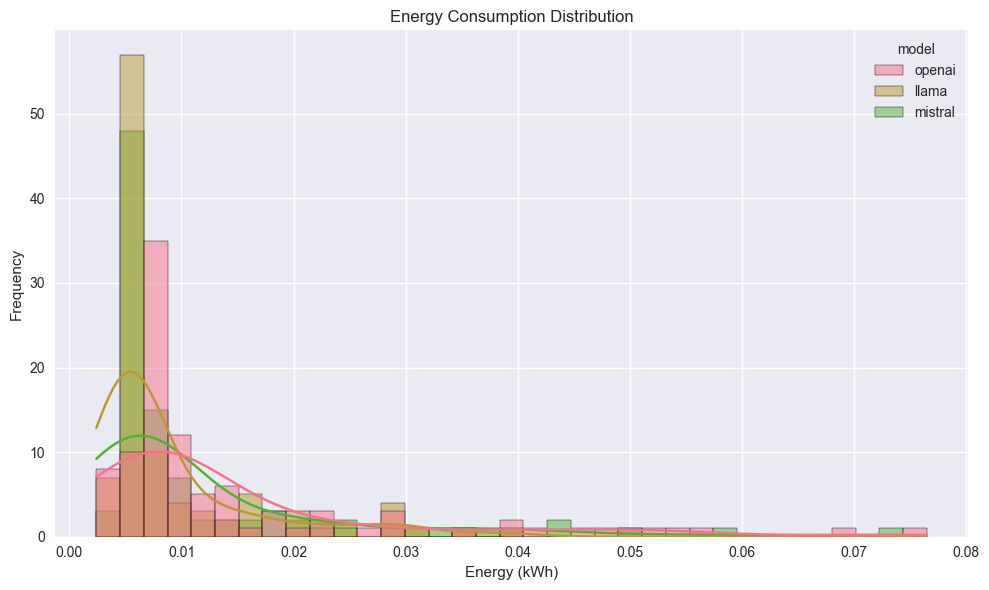

In [47]:
# Energy Distribution
if not df.empty:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='estimated_energy_kwh', hue='model', kde=True)
    plt.title('Energy Consumption Distribution')
    plt.xlabel('Energy (kWh)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
else:
    print("No data available.")


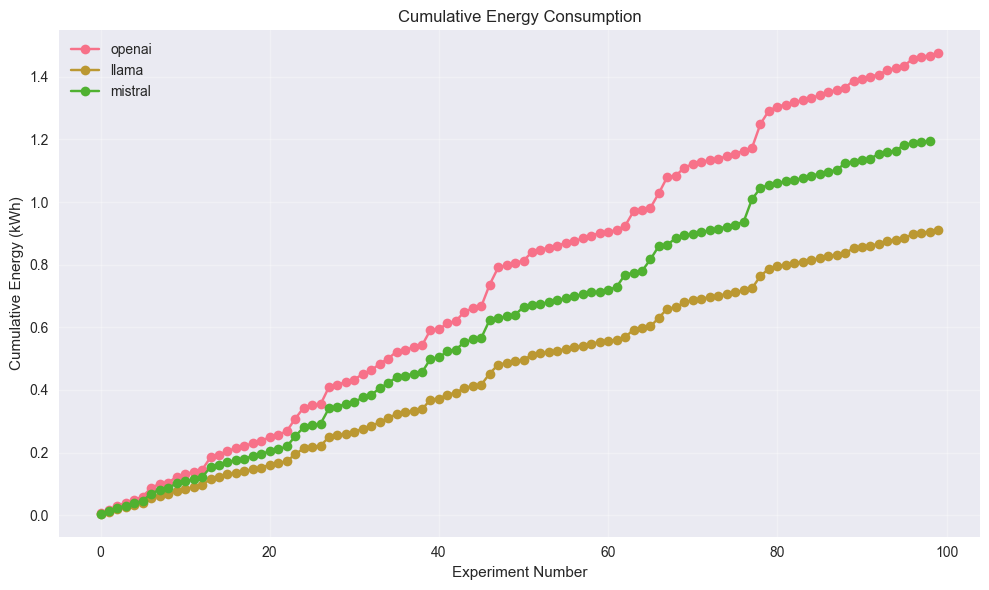

In [48]:
# Cumulative Energy Consumption
if not df.empty:
    plt.figure(figsize=(10, 6))
    for model in df['model'].unique():
        model_data = df[df['model'] == model]
        model_cumulative = model_data['estimated_energy_kwh'].cumsum()
        plt.plot(range(len(model_cumulative)), model_cumulative, label=model, marker='o')
    plt.xlabel('Experiment Number')
    plt.ylabel('Cumulative Energy (kWh)')
    plt.title('Cumulative Energy Consumption')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No data available.")


In [49]:
# Interactive 3D Visualization
if not df.empty:
    # Create interactive 3D scatter plot
    fig = px.scatter_3d(df, 
                        x='total_tokens', 
                        y='duration_seconds', 
                        z='estimated_energy_kwh',
                        color='model',
                        size='tokens_per_second',
                        hover_data=['prompt_id', 'tokens_per_second'],
                        title='3D Performance Analysis: Tokens vs Time vs Energy')
    
    fig.update_layout(
        scene=dict(
            xaxis_title='Total Tokens',
            yaxis_title='Duration (seconds)',
            zaxis_title='Energy (kWh)'
        ),
        width=800,
        height=600
    )
    
    fig.show()
    
    # Create correlation heatmap
    numeric_cols = ['duration_seconds', 'total_tokens', 'tokens_per_second', 'estimated_energy_kwh']
    correlation_matrix = df[numeric_cols].corr()
    
    fig2 = px.imshow(correlation_matrix, 
                    text_auto=True, 
                    aspect="auto",
                    title='Performance Metrics Correlation Matrix')
    fig2.show()
else:
    print("No data available for interactive plots.")


In [50]:
# Efficiency Metrics and Rankings
if not df.empty:
    # Calculate efficiency metrics
    efficiency_metrics = df.groupby('model').agg({
        'tokens_per_second': 'mean',
        'duration_seconds': 'mean',
        'estimated_energy_kwh': ['sum', 'mean'],
        'total_tokens': 'sum'
    }).round(4)
    
    # Flatten column names
    efficiency_metrics.columns = ['avg_speed', 'avg_duration', 'total_energy', 'avg_energy_per_response', 'total_tokens']
    
    # Calculate efficiency scores
    efficiency_metrics['speed_score'] = efficiency_metrics['avg_speed'] / efficiency_metrics['avg_speed'].max()
    efficiency_metrics['energy_efficiency'] = efficiency_metrics['total_tokens'] / efficiency_metrics['total_energy']
    efficiency_metrics['overall_efficiency'] = (efficiency_metrics['speed_score'] + efficiency_metrics['energy_efficiency'] / efficiency_metrics['energy_efficiency'].max()) / 2
    
    print("Efficiency Rankings:")
    speed_ranking = efficiency_metrics.sort_values('avg_speed', ascending=False)
    for i, (model, row) in enumerate(speed_ranking.iterrows(), 1):
        print(f"  {i}. {model}: {row['avg_speed']:.1f} tokens/sec")
    
    print("\nEnergy Efficiency (tokens per kWh):")
    energy_ranking = efficiency_metrics.sort_values('energy_efficiency', ascending=False)
    for i, (model, row) in enumerate(energy_ranking.iterrows(), 1):
        print(f"  {i}. {model}: {row['energy_efficiency']:.0f} tokens/kWh")
    
    print("\nDetailed Metrics:")
    print(efficiency_metrics.round(4))
else:
    print("No data available.")


Efficiency Rankings:
  1. llama: 424.3 tokens/sec
  2. openai: 189.0 tokens/sec
  3. mistral: 50.6 tokens/sec

Energy Efficiency (tokens per kWh):
  1. llama: 20001 tokens/kWh
  2. mistral: 12500 tokens/kWh
  3. openai: 10000 tokens/kWh

Detailed Metrics:
         avg_speed  avg_duration  total_energy  avg_energy_per_response  \
model                                                                     
llama     424.3399        0.4406        0.9094                   0.0091   
mistral    50.6437        5.1872        1.1955                   0.0121   
openai    188.9974        1.0058        1.4744                   0.0147   

         total_tokens  speed_score  energy_efficiency  overall_efficiency  
model                                                                      
llama           18189       1.0000         20001.0996              1.0000  
mistral         14944       0.1193         12500.2091              0.3722  
openai          14744       0.4454         10000.0000           

Cost Analysis:
  LLAMA: $0.0018 total, $0.000018 per response
  MISTRAL: $0.0030 total, $0.000030 per response
  OPENAI: $0.0022 total, $0.000022 per response

Total: $0.0070 cost, 3.579370 kWh, 47,877 tokens


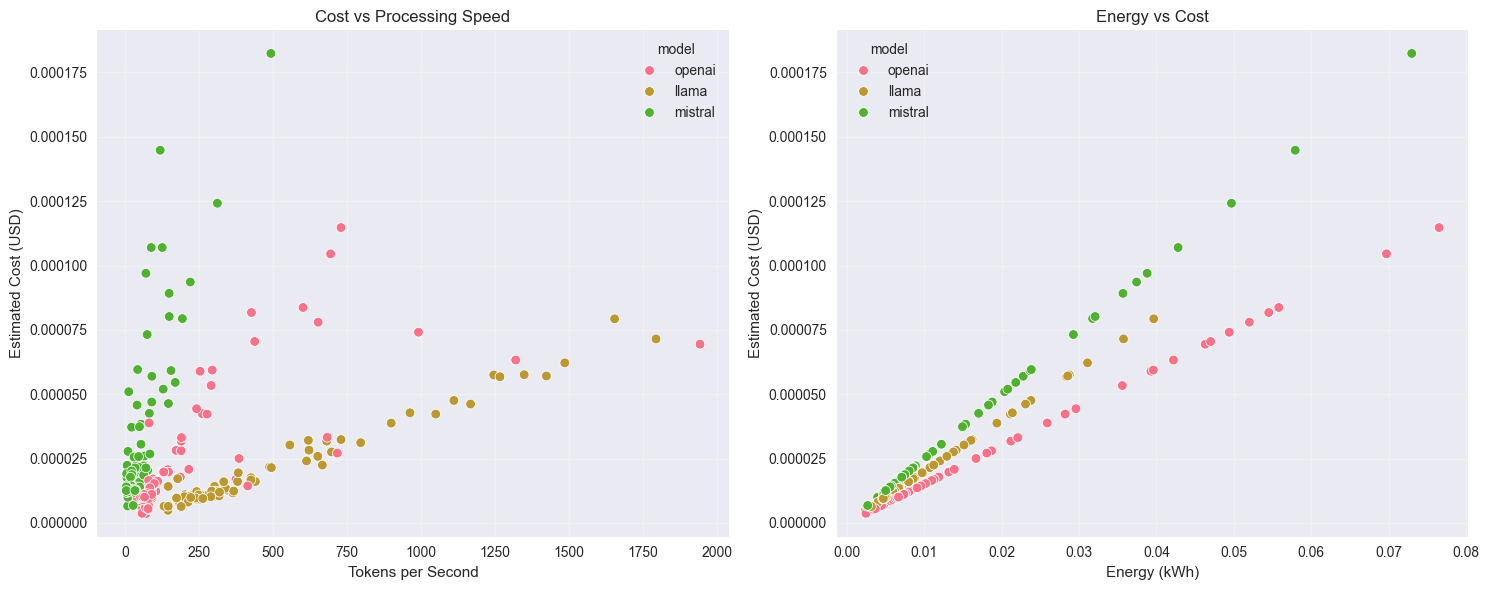

In [51]:
# Cost and Resource Analysis
if not df.empty:
    # Estimate costs (these are rough estimates - actual costs depend on API pricing)
    cost_estimates = {
        'openai': 0.00015,  # $0.15 per 1K tokens (GPT-4o-mini)
        'llama': 0.0001,    # $0.10 per 1K tokens (Groq)
        'mistral': 0.0002   # $0.20 per 1K tokens (Mistral)
    }
    
    # Calculate estimated costs
    df['estimated_cost'] = df.apply(lambda row: (row['total_tokens'] / 1000) * cost_estimates.get(row['model'], 0.00015), axis=1)
    
    cost_analysis = df.groupby('model').agg({
        'estimated_cost': ['sum', 'mean'],
        'total_tokens': 'sum',
        'estimated_energy_kwh': 'sum'
    }).round(6)
    
    cost_analysis.columns = ['total_cost', 'avg_cost_per_response', 'total_tokens', 'total_energy']
    
    print("Cost Analysis:")
    for model, row in cost_analysis.iterrows():
        print(f"  {model.upper()}: ${row['total_cost']:.4f} total, ${row['avg_cost_per_response']:.6f} per response")
    
    total_cost = cost_analysis['total_cost'].sum()
    total_energy = cost_analysis['total_energy'].sum()
    total_tokens = cost_analysis['total_tokens'].sum()
    
    print(f"\nTotal: ${total_cost:.4f} cost, {total_energy:.6f} kWh, {total_tokens:,} tokens")
    
    # Cost vs Performance visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Cost vs Speed
    sns.scatterplot(data=df, x='tokens_per_second', y='estimated_cost', hue='model', ax=axes[0])
    axes[0].set_title('Cost vs Processing Speed')
    axes[0].set_xlabel('Tokens per Second')
    axes[0].set_ylabel('Estimated Cost (USD)')
    axes[0].grid(True, alpha=0.3)
    
    # Energy vs Cost
    sns.scatterplot(data=df, x='estimated_energy_kwh', y='estimated_cost', hue='model', ax=axes[1])
    axes[1].set_title('Energy vs Cost')
    axes[1].set_xlabel('Energy (kWh)')
    axes[1].set_ylabel('Estimated Cost (USD)')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available.")


In [52]:
# Final Summary
if not df.empty:
    print(f"Summary: {len(df)} experiments, {df['total_tokens'].sum():,} tokens, {df['estimated_energy_kwh'].sum():.6f} kWh")
    print(f"Fastest: {df.groupby('model')['tokens_per_second'].mean().idxmax()}, Most efficient: {df.groupby('model')['energy_per_token'].mean().idxmin()}")
else:
    print("No data available.")


Summary: 299 experiments, 47,877 tokens, 3.579370 kWh
Fastest: llama, Most efficient: llama
